In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import os, json, csv
from shapely.geometry import Point, Polygon
import pandas as pd
import geopandas as gpd
from joblib import Parallel, delayed

In [3]:
import mpl_toolkits
mpl_toolkits.__path__.append('/usr/local/lib/python2.7/dist-packages/mpl_toolkits/')
from mpl_toolkits.basemap import Basemap
# define standard US projection map once for all (Albers equal area)
themap = Basemap(llcrnrlon=-130,llcrnrlat=24,urcrnrlon=-65,urcrnrlat=50, epsg=2163)

In [6]:
# global setting for including watermarks in plots
wm = True

In [44]:
def col_alpha_rescale(percentD,percentR, scale=0.4):
    """ Return RGBA color according to D, R vote percents, namely blue if D>R and red otherwise, 
    with transparency A set by vote difference fully opaque colors at and above input parameter scale (default=0.4)"""
    red, blue = (0., 1.) if percentD > percentR else (1.,0.)
    alpha = min(max(0.2 + 0.8*(np.abs(percentD-percentR)/(scale)),0),1)
    return  (red, 0, blue,alpha)

In [2]:
def millify(n, millnames = ['n','u','m','','k','M','B','T']):
    i_zero = millnames.index('')
    n = float(n)
    millidx = max(0,i_zero+min(len(millnames)-1,  int(np.floor(0 if n == 0 else np.log10(abs(n))/3))))
    strformat = '{:.1f}{}' if i_zero==0 and n<1 else '{:.0f}{}'
    return strformat.format(n / 10**(3 * (millidx-i_zero)), millnames[millidx])
# for n in (1.23456789 * 10**r for r in range(-9, 13, 1)):
#     print('%25.9f: %20s' % (n,millify(n)))

# import data

In [7]:
with open(os.path.join('input','usa-2016-presidential-election-by-county.json')) as f:
    data = json.load(f)

In [8]:
for idx in [3074]:
    data[idx]['fields']['votes']= 2857
    data[idx]['fields']['votes16_clintonh']= 2510
    data[idx]['fields']['votes16_trumpd']= 241
    data[idx]['fields']['votes16_steinj']= 0
    data[idx]['fields']['votes16_johnsong']= 106 
    data[idx]['fields']['total08']= 3712
    data[idx]['fields']['dem08_frac']= 100.*1637/3712
    data[idx]['fields']['rep08_frac']= 100.*2075/3712
    data[idx]['fields']['total12']= 3692
    data[idx]['fields']['dem12_frac']= 100.*1302/3692
    data[idx]['fields']['rep12_frac']= 100.*2262/3692
data[3117]['fields']['st']=u'VA'

In [9]:
n_counties = len(data)
good_counties0 = [idx for idx in range(n_counties) if 'votes' in data[idx]['fields']]
print 'Counties with election result data: %1d/%2d' %(len(good_counties0),n_counties)
print 'Missing information from following states:', list(set([data[idx]['fields']['st'] for idx in range(n_counties) if idx not in good_counties0]))

Counties with election result data: 3112/3143
Missing information from following states: [u'VA', u'AK', u'HI']


Import Alaska data, merge into dataset

In [311]:
akdf = pd.read_csv(os.path.join('input','Alaska2016.csv'))
akdf = akdf.drop([len(akdf)-1]).sort_values('ED/Muni')
akdf = akdf.reset_index(drop=True )
akdf = akdf[['ED/Muni','SL Total','TotPCT Trump,N,19,10','TotPCT Clinton,N,19,10','TotPCT Johnson,N,19,10','TotPCT Stein,N,19,10']]
# akdf.head()
akdf12 = pd.read_csv(os.path.join('input','Alaska2012.csv'))
akdf12 = akdf12.drop([len(akdf12)-1]).sort_values('ED/Muni')
akdf12 = akdf12.reset_index(drop=True )
akdf12 = akdf12[['ED/Muni','SL Total','SLTotPCT Romney,N,19,10','SLTotPCT Obama,N,19,10']]
# akdf12.head()

akdf08 = pd.read_csv(os.path.join('input','Alaska2008.csv'))
akdf08 = akdf08.drop([len(akdf08)-1]).sort_values('Municipality')
akdf08 = akdf08.reset_index(drop=True )
akdf08 = akdf08[['Municipality','SL Total Voters','SL PCT McCain','SL PCT Obama']]
# akdf08.head()

In [11]:
idx_ak = [(data[idx]['fields']['county'],idx) for idx in range(n_counties) if data[idx]['fields']['st']=='AK']
idx_ak = [ [x[1], x[0].split(',')[0]] for x in sorted(idx_ak)]

In [312]:
for ii, idx in enumerate(idx_ak):
    data[idx[0]]['fields']['votes'] = int(akdf.iloc[[ii]]['SL Total'].tolist()[0])
    data[idx[0]]['fields']['votes16_trumpd'] = int(akdf.iloc[[ii]]['TotPCT Trump,N,19,10'].tolist()[0] * int(akdf.iloc[[ii]]['SL Total'].tolist()[0]))
    data[idx[0]]['fields']['votes16_clintonh'] = int(akdf.iloc[[ii]]['TotPCT Clinton,N,19,10'].tolist()[0] * int(akdf.iloc[[ii]]['SL Total'].tolist()[0]))
    data[idx[0]]['fields']['votes16_steinj'] = int(akdf.iloc[[ii]]['TotPCT Johnson,N,19,10'].tolist()[0] * int(akdf.iloc[[ii]]['SL Total'].tolist()[0]))
    data[idx[0]]['fields']['votes16_johnsong'] = int(akdf.iloc[[ii]]['TotPCT Stein,N,19,10'].tolist()[0] * int(akdf.iloc[[ii]]['SL Total'].tolist()[0]))
    data[idx[0]]['fields']['dem12_frac'] = 100.*akdf12.iloc[[ii]]['SLTotPCT Obama,N,19,10'].tolist()[0]
    data[idx[0]]['fields']['rep12_frac'] = 100.*akdf12.iloc[[ii]]['SLTotPCT Romney,N,19,10'].tolist()[0]
    data[idx[0]]['fields']['total12'] = int(akdf12.iloc[[ii]]['SL Total'].tolist()[0])
    data[idx[0]]['fields']['dem08_frac'] = 100.*akdf08.iloc[[ii]]['SL PCT Obama'].tolist()[0]
    data[idx[0]]['fields']['rep08_frac'] = 100.*akdf08.iloc[[ii]]['SL PCT McCain'].tolist()[0]
    data[idx[0]]['fields']['total08'] = int(akdf08.iloc[[ii]]['SL Total Voters'].tolist()[0])

In [15]:
name_counties = [data[idx]['fields']['county'] for idx in range(n_counties)]
# states (long form)
states = sorted(list(set([name.split(',')[1].strip() for name in name_counties])))
# states (short form, but sorted according to long form)
states_short = set( [(data[idx]['fields']['state'],data[idx]['fields']['st']) for idx in range(n_counties)])
states_short = [x[1] for x in sorted(states_short, key = lambda x: x[0])]

In [16]:
good_counties = [idx for idx in range(n_counties) if 'votes' in data[idx]['fields']]
bad_counties = [idx for idx in range(n_counties) if 'votes' not in data[idx]['fields']]
len(states), len(states_short)
len(good_counties), len(name_counties)

(51, 51)

(3141, 3143)

Aggregate county data into state-level data

In [18]:
dictionary = {}
for st in states_short:
    dictionary[st]={}
    dictionary[st]['votes'] = sum([ data[idx]['fields']['votes'] for idx in good_counties if data[idx]['fields']['st']==st])
    dictionary[st]['total_population'] = sum([ data[idx]['fields']['total_population'] for idx in good_counties if data[idx]['fields']['st']==st])
    dictionary[st]['D'] = sum([ data[idx]['fields']['votes16_clintonh'] for idx in good_counties if data[idx]['fields']['st']==st])
    dictionary[st]['R'] = sum([ data[idx]['fields']['votes16_trumpd'] for idx in good_counties if data[idx]['fields']['st']==st])
    dictionary[st]['G'] = sum([ data[idx]['fields']['votes16_steinj'] for idx in good_counties if data[idx]['fields']['st']==st and 'votes16_steinj' in data[idx]['fields']])
    dictionary[st]['L'] = sum([ data[idx]['fields']['votes16_johnsong'] for idx in good_counties if data[idx]['fields']['st']==st])
#     dictionary[st]['votes08'] = sum([ data[idx]['fields']['total08'] for idx in good_counties if data[idx]['fields']['st']==st])
#     dictionary[st]['votes12'] = sum([ data[idx]['fields']['total12'] for idx in good_counties if data[idx]['fields']['st']==st])
#     dictionary[st]['D08'] = sum([ data[idx]['fields']['dem08_frac']/100*data[idx]['fields']['total08'] for idx in good_counties if data[idx]['fields']['st']==st])
#     dictionary[st]['R08'] = sum([ data[idx]['fields']['rep08_frac']/100*data[idx]['fields']['total08'] for idx in good_counties if data[idx]['fields']['st']==st])
#     dictionary[st]['D12'] = sum([ data[idx]['fields']['dem12_frac']/100*data[idx]['fields']['total12'] for idx in good_counties if data[idx]['fields']['st']==st])
#     dictionary[st]['R12'] = sum([ data[idx]['fields']['rep12_frac']/100*data[idx]['fields']['total12'] for idx in good_counties if data[idx]['fields']['st']==st])

In [22]:
counties_borders = {}
for idx in good_counties:
    try: border = data[idx]['fields']['geo_shape']
    except: 
        print "no geo_shape: index = %1d, %2s. Population = %3d" % (idx, data[idx]['fields']['county'], data[idx]['fields']['total_population'])
        continue
    if len(border['coordinates'])>1:
        try: main_pol = max( border['coordinates'], key= lambda x: Polygon(x[0]).area)[0]
        except: main_pol = max( border['coordinates'], key= lambda x: Polygon(x).area)
    else: main_pol = border['coordinates'][0]
    # move Hawaii/Alaska near continental US
    if data[idx]['fields']['st'] == 'HI': main_pol = list(np.array(map(lambda (x,y): [x+53,y+7], main_pol)))
    elif data[idx]['fields']['st'] == 'AK': main_pol = list(np.array(map(lambda (x,y): [0.32*x-65,0.44*y], main_pol)))
    # move Aleutians West below AK
    if idx == 2677: main_pol = list(np.array(map(lambda (x,y): [x+2,y+1], main_pol)))
    counties_borders[idx] = main_pol
print 'County geometry available for %1d/%2d counties...' %( len(counties_borders), len(good_counties))

no geo_shape: index = 21, Pike County, Georgia. Population = 17440
no geo_shape: index = 249, Schley County, Georgia. Population = 4569
no geo_shape: index = 974, Williamsburg city, Virginia. Population = 13199
no geo_shape: index = 1426, Marshall County, Alabama. Population = 90472
no geo_shape: index = 1669, Roane County, Tennessee. Population = 53683
no geo_shape: index = 1680, Washington County, Virginia. Population = 53711
no geo_shape: index = 2385, Terrell County, Georgia. Population = 9839
County geometry available for 3134/3141 counties...


In [23]:
county_density = {}
for idx in counties_borders.keys():
    projected_poly = np.array(themap(*np.array(counties_borders[idx]).T)).T
    county_density[idx] = 1609.34**2 * data[idx]['fields']['total_population'] / Polygon(projected_poly).area

# correlations in data

In [24]:
skiplist = ['geo','votes','temp','st','dem','rep','other','liber','green','county','name','aut','win','sum','spr','annual','lat','lon','total','elev',
            'precip','nearest']
sorted([ k for k in data[0]['fields'].keys() if all([not k.startswith(w) for w in skiplist])])

[u'acfs',
 u'adult_obesity',
 u'adult_smoking',
 u'adults_65_and_older_living_in_poverty',
 u'african_american_population',
 u'amerindian',
 u'asian',
 u'asian_american_population',
 u'at_least_bachelor_s_degree',
 u'at_least_high_school_diploma',
 u'black',
 u'ca',
 u'cfs',
 u'child_poverty_living_in_families_below_the_poverty_line',
 u'children_in_single_parent_households',
 u'children_under_6_living_in_poverty',
 u'construction_extraction_maintenance_and_repair_occupations',
 u'diabetes',
 u'est_votes_remaining',
 u'farming_fishing_and_forestry_occupations',
 u'fips',
 u'gini_coefficient',
 u'graduate_degree',
 u'hispanic',
 u'hiv_prevalence_rate',
 u'homicide_rate',
 u'infant_mortality',
 u'injury_deaths',
 u'less_than_high_school',
 u'low_birthweight',
 u'management_professional_and_related_occupations',
 u'mar',
 u'maxalc',
 u'meanalc',
 u'median_age',
 u'median_earnings_2010_dollars',
 u'mixedness',
 u'native_american_population',
 u'poor_mental_health_days',
 u'poor_physical_he

In [26]:
sortedlist = sorted(county_density.keys(), key = lambda x: abs((1.*data[x]['fields']['votes16_clintonh']-data[x]['fields']['votes16_trumpd'])/data[x]['fields']['votes']), reverse=True)
marksizes = lambda tot: map(lambda x: max(x,5),(np.sqrt(tot)-15))

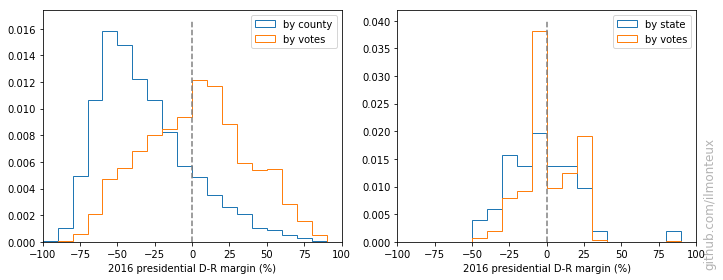

In [151]:
vv = [100*(1.*data[idx]['fields']['votes16_clintonh']-data[idx]['fields']['votes16_trumpd'])/data[idx]['fields']['votes'] for idx in sortedlist]
vvs = [100*(1.*dictionary[st]['D']-dictionary[st]['R'])/dictionary[st]['votes'] for st in states_short]
totD, totR = [xv[0] for xv in zip(tot,vv) if xv[1]>0], [xv[0] for xv in zip(tot,vv) if xv[1]<0]
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].hist(vv, bins=np.arange(-100,105,10),density=True, histtype='step',label='by county')
axes[0].hist(vv, bins=np.arange(-100,105,10),weights=tot,density=True, histtype='step',label='by votes')
axes[1].hist(vvs, bins=np.arange(-100,105,10),density=True, histtype='step',label='by state')
axes[1].hist(vvs, bins=np.arange(-100,105,10),density=True, weights=[dictionary[st]['votes'] for st in states_short], histtype='step',label='by votes')
for ax in axes:
    ax.set(xlabel='2016 presidential D-R margin (%)', xlim=(-100,100))
    ax.vlines(0,0,ax.get_ylim()[1],colors='gray',linestyles='--')
    ax.legend();
if wm: _=plt.text(1.0, 0.05, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3,transform =plt.gca().get_figure().transFigure)
fig.tight_layout();

In [149]:
fig.savefig('figs/dist_margin_by_county_state.png')

In [97]:
# histogram plotting parameters, same for most histo plots
histspecs = dict(density=True,color=['b','r'], histtype='step')

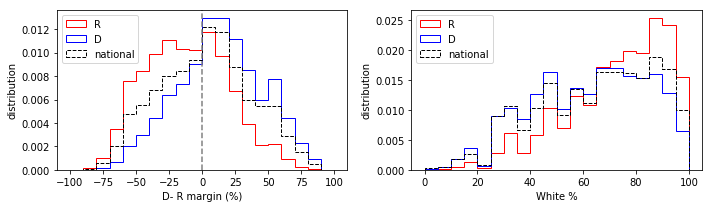

In [115]:
fig, haxes = plt.subplots(1,2,figsize=(10,3))
vvD, vvR =  [data[idx]['fields']['votes16_clintonh'] for idx in sortedlist], [data[idx]['fields']['votes16_trumpd'] for idx in sortedlist]
haxes[0].hist([vv,vv] ,bins=np.arange(-100,105,10), weights=[vvD,vvR], label = ['D','R'], **histspecs)
haxes[0].hist(vv,bins=np.arange(-100,105,10), weights=tot, density=True, color='k', ls='--', histtype='step',label='national')
haxes[1].hist([ww,ww],bins=np.arange(0,105,5),  weights=[vvD,vvR],label = ['D','R'], **histspecs);
haxes[1].hist(ww,bins=np.arange(0,105,5), weights=tot, density=True, color='k', ls='--', histtype='step', label='national')
for hax in haxes: hax.legend(loc='upper left');
for ih, hax in enumerate(haxes): 
    hax.set_ylim(bottom=0,top=None), hax.set(ylabel='distribution',  xlabel=['D- R margin (%)','White %'][ih])
haxes[0].vlines(0,0,1,colors='gray',linestyles='--')
plt.tight_layout();

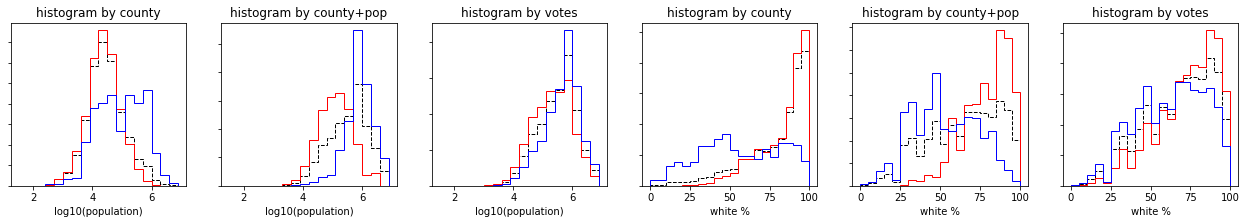

In [633]:
fig, haxes = plt.subplots(1,6,figsize=(22,3))
totD, totR = [xv[0] for xv in zip(tot,vv) if xv[1]>0], [xv[0] for xv in zip(tot,vv) if xv[1]<0]
vvD, vvR =  [data[idx]['fields']['votes16_clintonh'] for idx in sortedlist], [data[idx]['fields']['votes16_trumpd'] for idx in sortedlist]
# vvD, vvR = [xv[0] for xv in zip(vvD,vv) if xv[1]>0], [xv[0] for xv in zip(vvR,vv) if xv[1]<0]
haxes[0].hist(np.log10(tot),bins=np.arange(1.5,7,0.3), density=True, color='k', ls='--', histtype='step')
haxes[0].hist([[xv[0] for xv in zip(np.log10(tot),vv) if xv[1]>0],[xv[0] for xv in zip(np.log10(tot),vv) if xv[1]<0]], bins=np.arange(1.5,7,0.3),**histspecs)
haxes[1].hist(np.log10(tot),bins=np.arange(1.5,7,0.3), weights=tot, density=True, color='k', ls='--', histtype='step')
haxes[1].hist([[xv[0] for xv in zip(np.log10(tot),vv) if xv[1]>0],[xv[0] for xv in zip(np.log10(tot),vv) if xv[1]<0]], bins=np.arange(1.5,7,0.3),weights=[totD,totR],**histspecs)
# haxes[2].hist([[xv[0] for xv in zip(np.log10(tot),vv) if xv[1]>0], [xv[0] for xv in zip(np.log10(tot),vv) if xv[1]<0]],bins=np.arange(1.5,7,0.3),alpha=0.7,density=True,color=['b','r'], histtype='step', weights=[vvD,vvR])
haxes[2].hist(np.log10(tot),bins=np.arange(1.5,7,0.3), weights=[data[idx]['fields']['votes'] for idx in sortedlist], density=True, color='k', ls='--', histtype='step')
haxes[2].hist([np.log10(tot),np.log10(tot)],bins=np.arange(1.5,7,0.3), weights=[vvD,vvR],**histspecs)
haxes[3].hist(ww,bins=np.arange(0,105,5), density=True, color='k', ls='--', histtype='step')
haxes[3].hist([[xv[0] for xv in zip(ww,vv) if xv[1]>0],[xv[0] for xv in zip(ww,vv) if xv[1]<0]], bins=np.arange(0,105,5),**histspecs)
haxes[4].hist(ww,bins=np.arange(0,105,5), weights=tot, density=True, color='k', ls='--', histtype='step')
haxes[4].hist([[xv[0] for xv in zip(ww,vv) if xv[1]>0],[xv[0] for xv in zip(ww,vv) if xv[1]<0]], bins=np.arange(0,105,5),weights=[totD,totR],**histspecs)
haxes[5].hist(ww,bins=np.arange(0,105,5), weights=[data[idx]['fields']['votes'] for idx in sortedlist], density=True, color='k', ls='--', histtype='step')
# haxes[5].hist([[xv[0] for xv in zip(ww,vv) if xv[1]>0], [xv[0] for xv in zip(ww,vv) if xv[1]<0]],bins=np.arange(0,105,5),alpha=0.7,density=True,color=['b','r'], histtype='step', weights=[vvD,vvR])
haxes[5].hist([ww,ww],bins=np.arange(0,105,5), weights=[vvD,vvR],**histspecs)
for ih, hax in enumerate(haxes):  haxes[ih].set(title='histogram by '+['county','county+pop','votes'][ih%3], xlabel=['log10(population)','white %'][ih//3],  yticklabels=[]);

Above one can see the big difference between the approaches. For example see the left 3 plots:   
- by county, most counties have 10k people, and R win most of them
- taking each county population in account, the distributions are peacked in the 100k-1M range. There, D win most high-populated ones, but R win many more lower populated ones (broader distributions)
- finally, weighing by the votes actually cast, the differences are even less pronounced. One could guess that abstention rates are higher in the small counties, which are more likely to be rural? I will try a simple linear fit below, and while there is some correlation, it's not great. Another hypothesis could be that largest counties are mostly democrat so if I weight only by the party that won those counties I get skewed results

In [131]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regrw = linear_model.LinearRegression()
ab = 1.*np.array([data[idx]['fields']['votes'] for idx in sortedlist])/np.array(tot)
X = np.array(np.log10(dd))[:].reshape(-1, 1)
Y = np.array(ab)[:].reshape(-1, 1)
W = ([data[idx]['fields']['votes']for idx in sortedlist])
regr.fit(X , Y )
regrw.fit(X , Y , sample_weight=W)
regr.coef_
regrw.coef_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

array([[-0.00991422]])

array([[-0.01913356]])

In [133]:
line = np.array(sorted(zip(X, regr.predict(X)),key=lambda x: x[0])).T[0]
linew = np.array(sorted(zip(X, regrw.predict(X)),key=lambda x: x[0])).T[0]

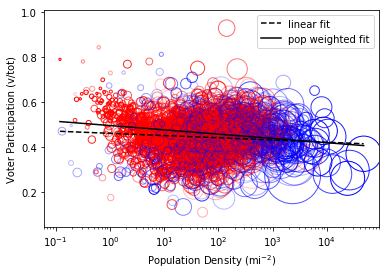

In [134]:
# _=plt.hist(1.*np.array([data[idx]['fields']['votes'] for idx in sortedlist])/np.array(tot),bins=np.arange(0,1,0.1))
fig, ax = plt.subplots()
ax.scatter(dd,ab,facecolor='none', edgecolor= cc, s=marksizes(tot))
ax.plot(10**line[0],line[1],c='k',ls='--',label='linear fit')
ax.plot(10**linew[0],linew[1],c='k',label='pop weighted fit')
# ax.plot(10**linew[0],linew[1],c='g')
ax.legend()
ax.set(xscale='log', xlabel='Population Density (mi$^{-2}$)', ylabel='Voter Participation (v/tot)');

Make a legend with concentric rings: in `scatter`, the marker size `s` is the marker (here, circle) area in pixels. Following the [matplotlib.transform](https://matplotlib.org/users/transforms_tutorial.html) tutorial, I use:
- `ax.transAxes`, which maps from Axes coordinates (lower-left=(0,0), upper right =(1,1)) to display coordinates (pixels, upper right=(width,height))
- I set the legend height in Axes coordinates (e.g. 0.5) and transform it to display coordinates via `ax.transAxes.transform()`
- the circle radius is markersize/2 in pixels (display coordinates), so I offset the vertical center of the circle by that amount, minus one pixel so it looks nice.
- then I use the inverted transAxes transofrmation to get back the point from pixel to Axes coordinates. and I draw a circle with plt.scatter, specifying that the input coordinates given are in Axes coordinates via the `transform=` specification.

In [41]:
def add_circle_legend(ax, xpos, ypos, yadj=1):
    """Add nested circle legend"""
    for i,nn in enumerate([10**3,10**4,10**5,10**6,10**7]):
        ms = marksizes([nn])
        ypos0 = ax.transAxes.inverted().transform([0,ax.transAxes.transform([0,ypos])[1]+(np.sqrt(ms)/2-yadj*i)])[1]
        ypos1 = ax.transAxes.inverted().transform([0,ax.transAxes.transform([0,ypos])[1]+2*(np.sqrt(ms)/2-yadj*i)+1.5*i])[1]
        ax.scatter(xpos,ypos0, s=ms, facecolor = 'none', edgecolor='k', transform=ax.transAxes)
        # unreadable for smaller numbers
        if nn>10**4:ax.text(xpos,ypos1, millify(nn), transform=ax.transAxes,ha='center')
    return ax

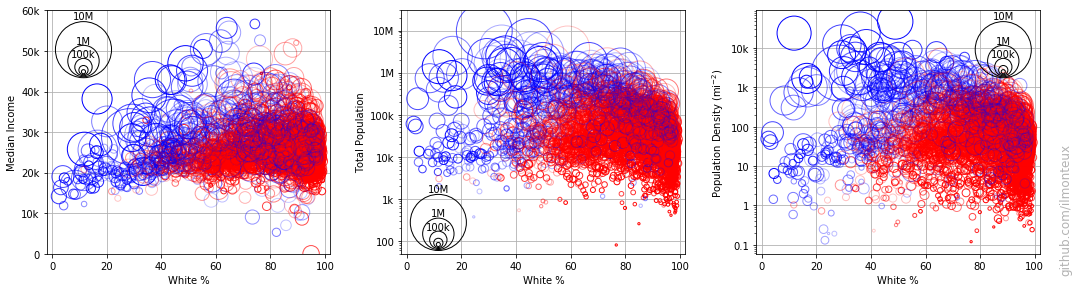

In [374]:
fig,axes =plt.subplots(1,3,figsize=(15,4))
for iax, ax in enumerate(axes): _ = ax.set_xlabel('White %'), ax.set_ylabel(['Median Income','Total Population','Population Density (mi$^{-2}$)'][iax]), 
ss = [data[idx]['fields']['median_earnings_2010_dollars'] for idx in sortedlist]
ww = [data[idx]['fields']['white'] for idx in sortedlist]
cc = [col_alpha_rescale(1.*data[idx]['fields']['votes16_clintonh']/data[idx]['fields']['votes'],
                        1.* data[idx]['fields']['votes16_trumpd']/data[idx]['fields']['votes'],0.8) for idx in sortedlist]
tot = [data[idx]['fields']['total_population'] for idx in sortedlist]
dd = [county_density[idx] for idx in sortedlist]
_=axes[0].scatter(ww, ss, facecolor = 'none', edgecolor= cc, s=marksizes(tot))
_=axes[1].scatter(ww, tot, facecolor = 'none', edgecolor= cc, s=marksizes(tot))
_=axes[2].scatter(ww, dd, facecolor = 'none', edgecolor= cc, s=marksizes(tot))
for ax in axes[1:]: _ = ax.set_yscale('log')
_= axes[0].set(yticks= 10**4*np.arange(-1,7),yticklabels =map(millify,10**4*np.arange(-1,7)),ylim=[0,60000])
_= axes[1].set(yticks= 10.**np.arange(2,8),yticklabels =map(millify, 10.**np.arange(2,8)),ylim=(50,3*10**7))
_= axes[2].set(yticks= 10.**np.arange(-1,6),yticklabels =map(lambda n : millify(n, ['','k','M','B','T']), 10.**np.arange(-1,7)))
fig.subplots_adjust(left=0.05, right=0.97, top=0.97, wspace=0.25, hspace=0);
for iax, ax in enumerate(axes): 
    ax = add_circle_legend(ax,[0.13,0.13,0.87][iax],[0.74,0.03,0.74][iax])
    ax.set(xlim=[-2,102],axisbelow=True)
    ax.grid(True)
if wm: fig.text(1.0, 0.05, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3);

In [375]:
fig.savefig('figs/scatter_demo_by_white.png')

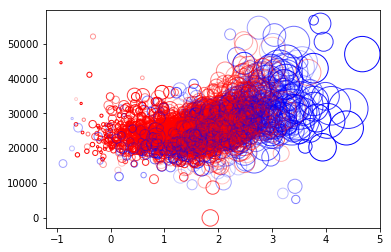

In [301]:
plt.scatter(np.log10(dd), ss, facecolor = 'none', edgecolor= cc, s=marksizes(tot))
# plt.xscale('log')
# plt.xlim(0.1,10)

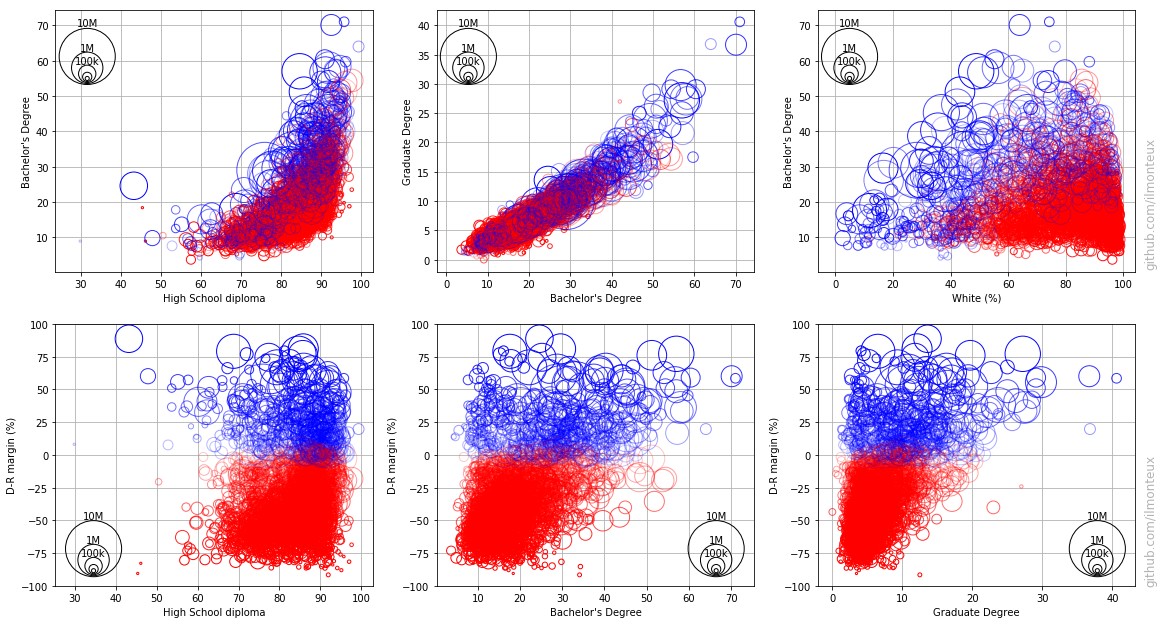

In [377]:
hsc =  [data[idx]['fields']['at_least_high_school_diploma'] for idx in sortedlist]
bb =  [data[idx]['fields']['at_least_bachelor_s_degree'] for idx in sortedlist]
gg =  [data[idx]['fields']['graduate_degree'] for idx in sortedlist]
vv = [100*(1.*data[idx]['fields']['votes16_clintonh']-data[idx]['fields']['votes16_trumpd'])/data[idx]['fields']['votes'] for idx in sortedlist]

fig,axes = plt.subplots(2,3,figsize=(15,8))
_ = axes[0][0].scatter(hsc,bb , facecolor = 'none', edgecolor= cc, s=marksizes(tot))
_ = axes[0][1].scatter(bb,gg , facecolor = 'none', edgecolor= cc, s=marksizes(tot))
_ = axes[0][2].scatter(ww,bb, facecolor = 'none', edgecolor= cc, s=marksizes(tot))

_ = axes[0][0].set(xlabel='High School diploma',ylabel="Bachelor's Degree")
_ = axes[0][1].set(ylabel='Graduate Degree',xlabel="Bachelor's Degree")
_ = axes[0][2].set( ylabel="Bachelor's Degree",xlabel='White (%)')
_ = axes[1][0].scatter(hsc,vv , facecolor = 'none', edgecolor= cc, s=marksizes(tot))
_ = axes[1][1].scatter(bb,vv , facecolor = 'none', edgecolor= cc, s=marksizes(tot))
_ = axes[1][2].scatter(gg,vv , facecolor = 'none', edgecolor= cc, s=marksizes(tot))

if wm: _=fig.text(1.02, 0.55, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3)
if wm: _=fig.text(1.02, 0.0, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.2, hspace=0.2);
for ax in axes[0]:   
    ax = add_circle_legend(ax,0.1,0.73)
    ax.set_axisbelow(True)
    ax.grid(True)
for iax, ax in enumerate(axes[1]): 
    _=ax.set(ylabel='D-R margin (%)',ylim=(-100,100), xlabel=['High School diploma',"Bachelor's Degree",'Graduate Degree'][iax],axisbelow=True)
    ax.grid(True)
    ax = add_circle_legend(ax,[0.12,0.88,0.88][iax],[0.05,0.05,0.05][iax]);


In the following will bin with respect to other variables.   
I can plot each county in a bin if it went D/R, or I can weigh it according to its population, or I can the D/R bins according to the D/R votes themselves (that is, weigh according to the D/R votes themselves).    
There is not really a **right** way to do it, the information conveyed is different in each case. For example, if it was House districts instead of counties, one would be interested in the distributions by district counts, not by population (obviously, house districts are weighted by population, so there will not be huge differences as in counties).

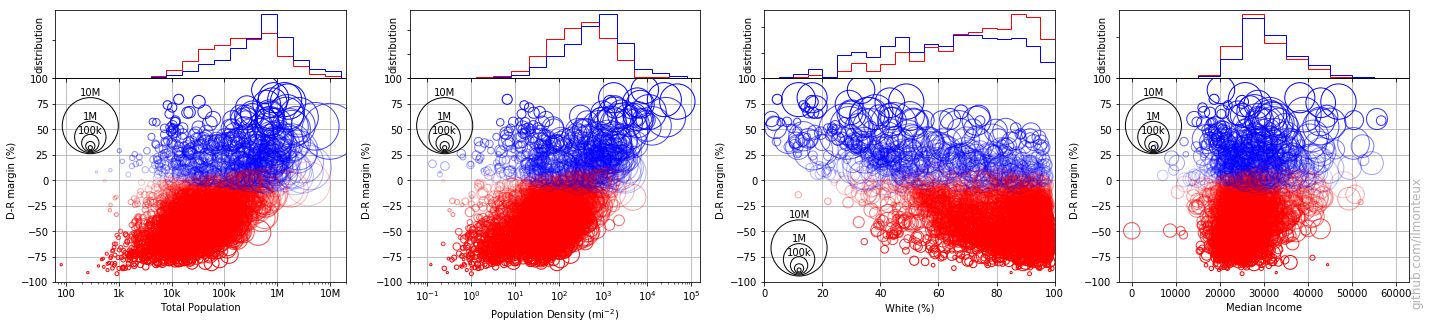

In [378]:
fig = plt.figure(figsize=(20, 5))
grid = plt.GridSpec(4, 4, hspace=0., wspace=0.22)
axes = [ fig.add_subplot(grid[1:, i]) for i in range(4)]
haxes = [ fig.add_subplot(grid[0, i], yticklabels=[], xticklabels=[]) for i in range(4)]
vv = [100*(1.*data[idx]['fields']['votes16_clintonh']-data[idx]['fields']['votes16_trumpd'])/data[idx]['fields']['votes'] for idx in sortedlist]

# haxes[0].hist([[xv[0] for xv in zip(np.log10(tot),vv) if xv[1]>0],[xv[0] for xv in zip(np.log10(tot),vv) if xv[1]<0]], bins=np.arange(1.8,7.3,0.3),weights=[totD,totR],**histspecs)
haxes[0].hist([np.log10(tot),np.log10(tot)], bins=np.arange(1.8,7.3,0.3),weights=[vvD,vvR],**histspecs)
haxes[0].set_xlim(1.8,7.3)
axes[0].scatter(tot, vv, facecolor = 'none', edgecolor= cc, s=marksizes(tot))
axes[0].set(xscale='log', xlim=10**np.array(haxes[0].get_xlim()),ylim=(-100,100), xlabel= 'Total Population', ylabel='D-R margin (%)')
axes[0].set(xticks= 10.**np.arange(2,8),xticklabels =map(millify, 10.**np.arange(2,8)));

# haxes[1].hist([[xv[0] for xv in zip(np.log10(dd),vv) if xv[1]>0],[xv[0] for xv in zip(np.log10(dd),vv) if xv[1]<0]], bins=np.arange(-1.1,5,0.4),weights=[totD,totR],**histspecs)
haxes[1].hist([np.log10(dd),np.log10(dd)], bins=np.arange(-1.1,5,0.4),weights=[vvD,vvR],**histspecs)
axes[1].scatter(dd, vv, facecolor = 'none', edgecolor= cc, s=marksizes(tot))
axes[1].set(xscale='log', xlim=10**np.array(haxes[1].get_xlim()), ylim=(-100,100), xlabel= 'Population Density (mi$^{-2}$)', ylabel='D-R margin (%)')

# haxes[1].hist([[xv[0] for xv in zip(ww,vv) if xv[1]>0],[xv[0] for xv in zip(ww,vv) if xv[1]<0]], bins=np.arange(0,105,5),weights=[totD,totR],**histspecs)
haxes[2].hist([ww,ww],bins=np.arange(0,105,5), weights=[vvD,vvR],**histspecs)
haxes[2].set_xlim(0,100)
axes[2].scatter(ww, vv, facecolor = 'none', edgecolor= cc, s=marksizes(tot))
axes[2].set(xlim=(0,100),ylim=(-100,100), xlabel= 'White (%)', ylabel='D-R margin (%)')

ss = [data[idx]['fields']['median_earnings_2010_dollars'] for idx in sortedlist]

# haxes[2].hist([[xv[0] for xv in zip(np.log10(uu),vv1) if xv[1]>0],[xv[0] for xv in zip(np.log10(uu),vv1) if xv[1]<0]], bins=np.arange(-1.9,-0.5,0.04),weights=[tot1D,tot1R],**histspecs)
haxes[3].hist([ss,ss], bins=np.arange(0,61*10**3,5*10**3),weights=[vvD,vvR],**histspecs)
haxes[3].set_xlim=(0,60000)
axes[3].scatter(ss, vv, facecolor = 'none', edgecolor= cc, s=marksizes(tot))
axes[3].set(ylim=(-100,100),xlim=haxes[3].get_xlim(), xlabel= 'Median Income', ylabel='D-R margin (%)');
for hax in haxes: _=hax.set_ylim(bottom=0,top=None), hax.set_ylabel('distribution'); #hax.set(yscale='log'); #would show distribution tails but easy to misinterpret
for ax in axes: 
    ax.set(axisbelow=True)
    ax.grid(True)
fig.subplots_adjust(left=0.05, right=0.99);

for iax in [0,1,3]:   axes[iax] = add_circle_legend(axes[iax],0.12,0.65)
axes[2] = add_circle_legend(axes[2],0.12,0.05)
if wm: fig.text(1, 0.05, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3);

In [379]:
fig.savefig('figs/scatter_margin_by_demo.png')

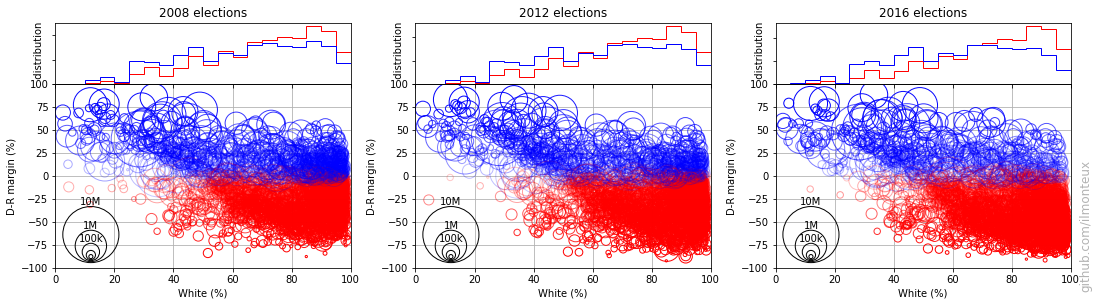

In [408]:
fig = plt.figure(figsize=(15, 4.5))
grid = plt.GridSpec(4, 3, hspace=0., wspace=0.22)
axes = [ fig.add_subplot(grid[1:, i]) for i in range(3)]
haxes = [ fig.add_subplot(grid[0, i], yticklabels=[], xticklabels=[]) for i in range(3)]
vv = [100*(1.*data[idx]['fields']['votes16_clintonh']-data[idx]['fields']['votes16_trumpd'])/data[idx]['fields']['votes'] for idx in sortedlist]
vv08 = [ data[idx]['fields']['dem08_frac']-data[idx]['fields']['rep08_frac'] for idx in sortedlist]
vvD08, vvR08 =  [data[idx]['fields']['dem08_frac']*data[idx]['fields']['total08']/100 for idx in sortedlist], [data[idx]['fields']['rep08_frac']*data[idx]['fields']['total08']/100 for idx in sortedlist]
cc08 = [col_alpha_rescale(data[idx]['fields']['dem08_frac']/100, data[idx]['fields']['rep08_frac']/100,0.8) for idx in sortedlist]
vv12 = [ data[idx]['fields']['dem12_frac']-data[idx]['fields']['rep12_frac'] for idx in sortedlist]
vvD12, vvR12 =  [data[idx]['fields']['dem12_frac']*data[idx]['fields']['total12']/100 for idx in sortedlist], [data[idx]['fields']['rep12_frac']*data[idx]['fields']['total12']/100 for idx in sortedlist]
cc12 = [col_alpha_rescale(1.*data[idx]['fields']['dem12_frac']/100, data[idx]['fields']['rep12_frac']/100,0.8) for idx in sortedlist]

haxes[0].hist([ww,ww],bins=np.arange(0,105,5), weights=[vvD08,vvR08],**histspecs)
haxes[0].set_xlim(0,100)
axes[0].scatter(ww, vv08, facecolor = 'none', edgecolor= cc08, s=marksizes(tot))

haxes[1].hist([ww,ww],bins=np.arange(0,105,5), weights=[vvD12,vvR12],**histspecs)
haxes[1].set_xlim(0,100)
axes[1].scatter(ww, vv12, facecolor = 'none', edgecolor= cc12, s=marksizes(tot))

haxes[2].hist([ww,ww],bins=np.arange(0,105,5), weights=[vvD,vvR],**histspecs)
haxes[2].set_xlim(0,100)
axes[2].scatter(ww, vv, facecolor = 'none', edgecolor= cc, s=marksizes(tot))

for ax in axes:
    ax.set(xlim=(0,100),ylim=(-100,100), xlabel= 'White (%)', ylabel='D-R margin (%)',axisbelow=True)
    ax.grid(True)
for iax,hax in enumerate(haxes): _=hax.set_ylim(bottom=0,top=None), hax.set(ylabel='  distribution',title= str([2008, 2012,2016][iax])+' elections'); #hax.set(yscale='log'); #would show distribution tails but easy to misinterpret
fig.subplots_adjust(left=0.05, right=0.99);

for ax in axes: ax = add_circle_legend(ax,0.12,0.05)
if wm: fig.text(1.01, 0.05, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3);

In [409]:
fig.savefig('figs/scatter_margin_by_white_081216.png')

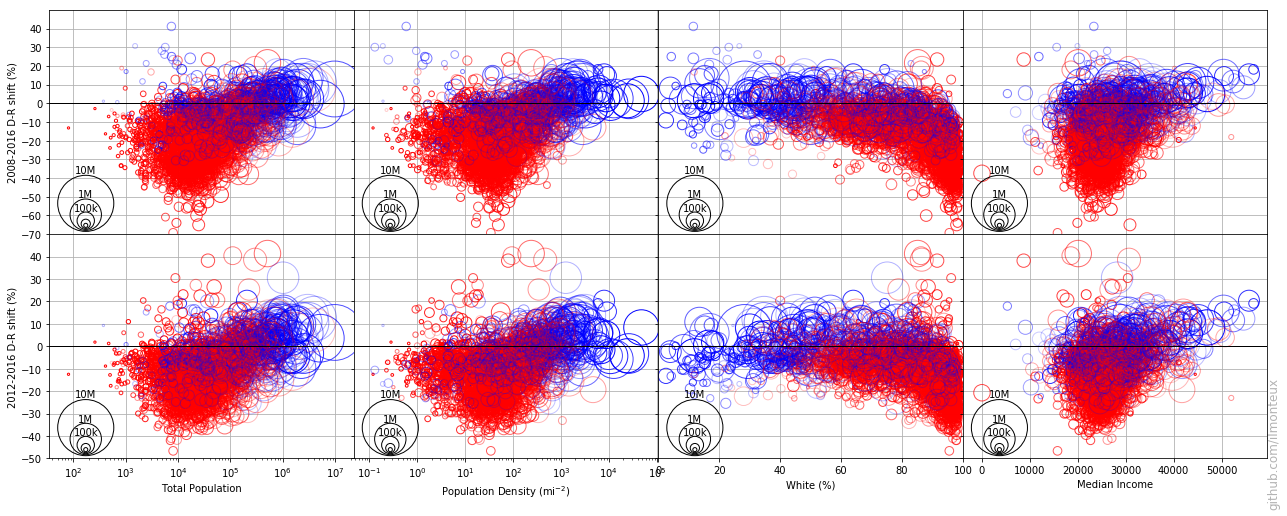

In [458]:
fig,axes = plt.subplots(2,4,figsize=(18,7))
fig.subplots_adjust(left=0.05, right=0.99, top=0.99, bottom=0.1, wspace=0, hspace=0)

shifts1216 = np.array(vv)-np.array(vv12)
shifts0816 = np.array(vv)-np.array(vv08)

for iax in range(2):
    axes[iax][0].set(xscale='log',  xlabel= 'Total Population', xticks= 10.**np.arange(2,8),xticklabels =map(millify, 10.**np.arange(2,8)))
    axes[iax][1].set(xscale='log', xlabel= 'Population Density (mi$^{-2}$)')
    axes[iax][2].set(xlim=(0,100), xlabel= 'White (%)')
    axes[iax][3].set(xlabel= 'Median Income');
    yrange = [(-70,50),(-50,50)][iax]
    for jax in range(4):
        axes[iax][jax].scatter([tot,dd,ww,ss][jax], [shifts0816,shifts1216][iax], facecolor = 'none', edgecolor= cc, s=marksizes(tot))
        axes[iax][jax].axhline(c='k',lw=1)
        axes[iax][jax].grid(True)
        axes[iax][jax].set(ylim=yrange, yticks = range(yrange[0],yrange[1],10),axisbelow=True)
        axes[0][jax].set(xticklabels=[])
        if jax>0: axes[iax][jax].set(yticklabels=[])
        else: axes[iax][jax].set(ylabel=str([2008,2012][iax])+'-2016 D-R shift (%)')
        axes[iax][jax] = add_circle_legend(axes[iax][jax],0.12,0.03)
if wm: fig.text(1, 0.0, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3);

In [459]:
fig.savefig('figs/scatter_shifts_by_demo.png')

Note: the red counties with a huge shift are mostly Mormons, where the 3rd party candidate McMullin drew a lot of votes (and 2012 republican candidate Romney also won by large margins)

In [405]:
print [data[idx]['fields']['county'] for idx in np.array(sortedlist)[np.array(shifts1216)>20]]

[u'Shannon County, South Dakota', u'Franklin County, Idaho', u'Rich County, Utah', u'Arlington County, Virginia', u'Sanpete County, Utah', u'Iron County, Utah', u'Box Elder County, Utah', u'Morgan County, Utah', u'Madison County, Idaho', u'Parmer County, Texas', u'Utah County, Utah', u'Tooele County, Utah', u'Cache County, Utah', u'Wasatch County, Utah', u'Davis County, Utah', u'Weber County, Utah', u'Salt Lake County, Utah']


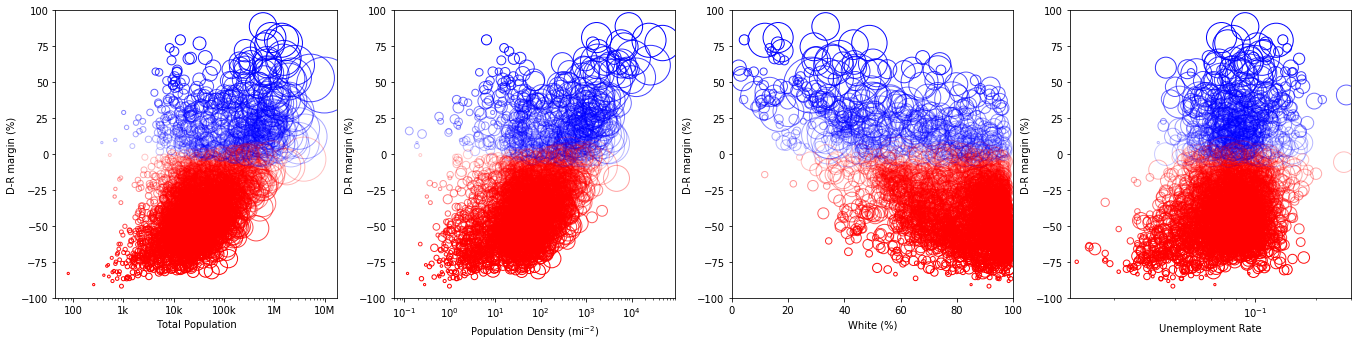

In [850]:
fig,axes = plt.subplots(1,4,figsize=(18,4))
vv = [100*(1.*data[idx]['fields']['votes16_clintonh']-data[idx]['fields']['votes16_trumpd'])/data[idx]['fields']['votes'] for idx in sortedlist]
_ = axes[0].scatter(tot, vv, facecolor = 'none', edgecolor= cc, s=marksizes(tot))
_ = axes[1].scatter(dd, vv, facecolor = 'none', edgecolor= cc, s=marksizes(tot))
_ = axes[2].scatter(ww, vv, facecolor = 'none', edgecolor= cc, s=marksizes(tot))

cc1 = [col_alpha_rescale(1.*data[idx]['fields']['votes16_clintonh']/data[idx]['fields']['votes'],
                        1.* data[idx]['fields']['votes16_trumpd']/data[idx]['fields']['votes'],0.8)
      for idx in sortedlist  if 'unemployment' in data[idx]['fields'].keys() ]
vv1 = [100*(1.*data[idx]['fields']['votes16_clintonh']-data[idx]['fields']['votes16_trumpd'])/data[idx]['fields']['votes'] for idx in sortedlist if 'unemployment' in data[idx]['fields'].keys() ]
uu = [data[idx]['fields']['unemployment'] for idx in sortedlist if 'unemployment' in data[idx]['fields'].keys() ]
tot1 = [data[idx]['fields']['total_population'] for idx in sortedlist if 'unemployment' in data[idx]['fields'].keys() ]
_ = axes[3].scatter(uu, vv1, facecolor = 'none', edgecolor= cc1, s=marksizes(tot1))

_ = axes[0].set(xscale='log', ylim=(-100,100), xlabel= 'Total Population', ylabel='D-R margin (%)')
_ = axes[0].set(xticks= 10.**np.arange(2,8),xticklabels =map(millify, 10.**np.arange(2,8)))
_ = axes[1].set(xscale='log', ylim=(-100,100), xlabel= 'Population Density (mi$^{-2}$)', ylabel='D-R margin (%)')
_ = axes[2].set(xlim=(0,100),ylim=(-100,100), xlabel= 'White (%)', ylabel='D-R margin (%)')
_ = axes[3].set(ylim=(-100,100),xscale='log',xlim=(0.012,0.3), xlabel= 'Unemployment Rate', ylabel='D-R margin (%)')
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.2, hspace=0)

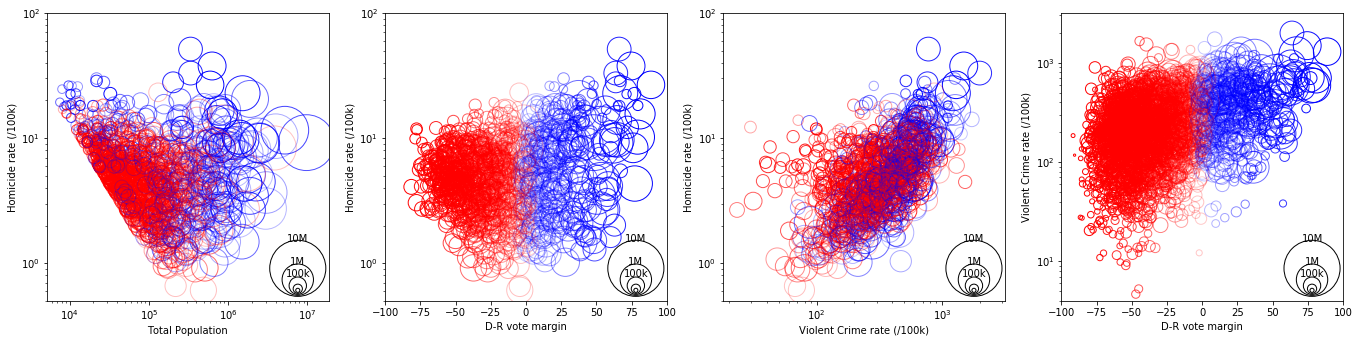

In [855]:
hh = [data[idx]['fields']['homicide_rate'] for idx in sortedlist if 'homicide_rate' in data[idx]['fields'].keys() ]
toth = [data[idx]['fields']['total_population'] for idx in sortedlist if 'homicide_rate' in data[idx]['fields'].keys() ]
vv = [100*(1.*data[idx]['fields']['votes16_clintonh']-data[idx]['fields']['votes16_trumpd'])/data[idx]['fields']['votes'] for idx in sortedlist  if 'homicide_rate' in data[idx]['fields'].keys() ]
cc = [col_alpha_rescale(1.*data[idx]['fields']['votes16_clintonh']/data[idx]['fields']['votes'],
                        1.* data[idx]['fields']['votes16_trumpd']/data[idx]['fields']['votes'],0.8)
      for idx in sortedlist  if 'homicide_rate' in data[idx]['fields'].keys() ]
vcr = [data[idx]['fields']['violent_crime'] for idx in sortedlist if 'violent_crime' in data[idx]['fields'].keys() ]
totv = [data[idx]['fields']['total_population'] for idx in sortedlist if 'violent_crime' in data[idx]['fields'].keys() ]
vv1 = [100*(1.*data[idx]['fields']['votes16_clintonh']-data[idx]['fields']['votes16_trumpd'])/data[idx]['fields']['votes'] for idx in sortedlist  if 'violent_crime' in data[idx]['fields'].keys() ]
cc1 = [col_alpha_rescale(1.*data[idx]['fields']['votes16_clintonh']/data[idx]['fields']['votes'],
                        1.* data[idx]['fields']['votes16_trumpd']/data[idx]['fields']['votes'],0.8)
      for idx in sortedlist  if 'violent_crime' in data[idx]['fields'].keys() ]
hhr = [data[idx]['fields']['homicide_rate'] for idx in sortedlist if 'homicide_rate' in data[idx]['fields'].keys() and 'violent_crime' in data[idx]['fields'].keys() ]
vcr1 = [data[idx]['fields']['violent_crime'] for idx in sortedlist if 'homicide_rate' in data[idx]['fields'].keys() and 'violent_crime' in data[idx]['fields'].keys() ]
totvh = [data[idx]['fields']['total_population'] for idx in sortedlist if 'homicide_rate' in data[idx]['fields'].keys() and 'violent_crime' in data[idx]['fields'].keys() ]
cc2 = [col_alpha_rescale(1.*data[idx]['fields']['votes16_clintonh']/data[idx]['fields']['votes'],
                        1.* data[idx]['fields']['votes16_trumpd']/data[idx]['fields']['votes'],0.8)
      for idx in sortedlist  if 'homicide_rate' in data[idx]['fields'].keys() and 'violent_crime' in data[idx]['fields'].keys() ]

fig,axes = plt.subplots(1,4,figsize=(18,4))
_=axes[0].scatter(toth, hh, facecolor = 'none', edgecolor= cc, s=marksizes(toth))
_ = axes[0].set(ylim=(.5,10**2),xscale='log', yscale='log', xlabel= 'Total Population', ylabel='Homicide rate (/100k)')
_ = axes[1].scatter(vv, hh, facecolor = 'none', edgecolor= cc, s=marksizes(toth))
_ = axes[1].set(ylim=(0.5,10**2), xlim=(-100,100),yscale='log', xlabel= 'D-R vote margin', ylabel='Homicide rate (/100k)')
_ = axes[2].scatter(vcr1, hhr, facecolor = 'none', edgecolor= cc2, s=marksizes(totvh))
_ = axes[2].set( ylim=(.5,10**2),xlim=(18,10**3.5),xscale='log',yscale='log', ylabel= 'Homicide rate (/100k)', xlabel='Violent Crime rate (/100k)')
_ = axes[3].scatter(vv1, vcr, facecolor = 'none', edgecolor= cc1, s=marksizes(totv))
_ = axes[3].set( xlim=(-100,100),ylim=(4,10**3.5),yscale='log', xlabel= 'D-R vote margin', ylabel='Violent Crime rate (/100k)')
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.2, hspace=0)
for iax in range(4):   axes[iax] = add_circle_legend(axes[iax],0.89,0.03,1)

In [146]:
for idx in [100, 667, 2032]:
    print name_counties[idx], [data[idx]['fields'][KK] for KK in ['violent_crime','homicide_rate']]

Monterey County, California [491.47, 8.28]
Orange County, California [229.73, 2.74]
Cook County, Illinois [696.89, 11.58]


Divide states into groups:

In [285]:
state_group = {}
state_group['New England'] = ['CT','ME','MA','NH','RI','VT']
state_group['Mid Atlantic'] = ['NY','NJ','PA']
state_group['Mid West I'] = ['IL','IN','MI','OH','WI']
state_group['Mid West II'] = ['IA','KS','MN','MO','NE','ND','SD']
state_group['South Atlantic'] = ['DE','DC','FL','GA','MD','NC','SC','VA','WV']
state_group['South I'] = ['AL','KY','MS','TN']
state_group['South II'] = ['AR','LA','OK','TX']
state_group['Mountain'] = ['AZ','CO','ID','MT','NV','NM','UT','WY']
state_group['Pacific'] = ['AK','CA','HI','OR','WA']

In [292]:
state_group = {}
state_group['North England'] = ['CT','ME','MA','NH','RI','VT','NY','NJ','PA']
state_group['Mid West'] = ['IL','IN','MI','OH','WI', 'IA','KS','MN','MO','NE','ND','SD']
state_group['South Atlantic'] = ['DE','DC','FL','GA','MD','NC','SC','VA','WV']
state_group['South'] = ['AL','KY','MS','TN', 'AR','LA','OK','TX']
state_group['Mountain'] = ['AZ','CO','ID','MT','NV','NM','UT','WY']
state_group['Pacific'] = ['AK','CA','HI','OR','WA']

In [281]:
state_short_to_long = {}
state_long_to_short = {}
for pair in zip(states,states_short):
    state_short_to_long[pair[1]] = pair[0]
    state_long_to_short[pair[0]] = pair[1]

In [248]:
counties_by_state = {}
for st in states:
    counties_by_state[state_long_to_short[st]] = [name.split(',')[0] for name in name_counties if name.split(',')[1].strip()==st]

In [282]:
def col_group(idx):
    for state in states:
        if name_counties[idx].endswith(state): st = state_long_to_short[state]
    for ii, rg in enumerate(state_group.keys()):
        if st in state_group[rg]:
            col = plt.get_cmap("tab10")(ii)
    return col

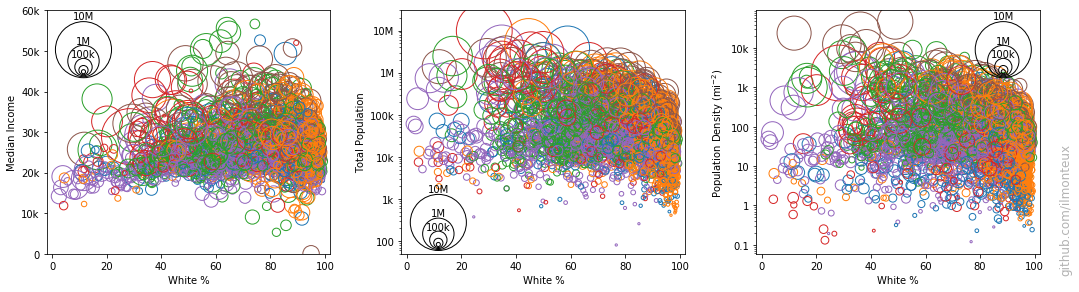

In [293]:
fig,axes =plt.subplots(1,3,figsize=(15,4))
for iax, ax in enumerate(axes): _ = ax.set_xlabel('White %'), ax.set_ylabel(['Median Income','Total Population','Population Density (mi$^{-2}$)'][iax]), 
ss = [data[idx]['fields']['median_earnings_2010_dollars'] for idx in county_density.keys()]
ww = [data[idx]['fields']['white'] for idx in county_density.keys()]
ccr = [col_group(idx) for idx in county_density.keys()]
tot = [data[idx]['fields']['total_population'] for idx in county_density.keys()]
dd = [county_density[idx] for idx in county_density.keys()]
_=axes[0].scatter(ww, ss, facecolor = 'none', edgecolor= ccr, s=marksizes(tot))
_=axes[1].scatter(ww, tot, facecolor = 'none', edgecolor= ccr, s=marksizes(tot))
_=axes[2].scatter(ww, dd, facecolor = 'none', edgecolor= ccr, s=marksizes(tot))
for ax in axes[1:]: _ = ax.set_yscale('log')
_= axes[0].set(yticks= 10**4*np.arange(-1,7),yticklabels =map(millify,10**4*np.arange(-1,7)),ylim=[0,60000])
_= axes[1].set(yticks= 10.**np.arange(2,8),yticklabels =map(millify, 10.**np.arange(2,8)),ylim=(50,3*10**7))
_= axes[2].set(yticks= 10.**np.arange(-1,6),yticklabels =map(lambda n : millify(n, ['','k','M','B','T']), 10.**np.arange(-1,7)))
fig.subplots_adjust(left=0.05, right=0.97, top=0.97, wspace=0.25, hspace=0);
for iax, ax in enumerate(axes): 
    ax = add_circle_legend(ax,[0.13,0.13,0.87][iax],[0.74,0.03,0.74][iax])
    ax.set_xlim([-2,102])
if wm: fig.text(1.0, 0.05, 'github.com/ilmonteux',fontsize=12, ha='right', va='bottom', rotation=90, alpha=0.3);